# Satellite image classification using Xception

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import Xception
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

/home/vitaliy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Global parameters
image_size = 256
train_folder = "Images/train/"
test_folder = "Images/test/"
train_batchsize = 64
val_batchsize = 16

In [5]:
def create_model_with_additional_layers(model_name, image_size):
    if model_name == "vgg16":
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "vgg19":
        pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "xception":
        pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "resnet50":
        pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionV3":
        pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionresnetV2":
        pretrained_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "mobilenet":
        pretrained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    else:
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    # Freeze all the layers
    for layer in pretrained_model.layers[:]:
        layer.trainable = False
    # Check the trainable status of the individual layers
    for layer in pretrained_model.layers:
        print(layer, layer.trainable)
    # Create the model
    model = models.Sequential()
    # Add the vgg convolutional base model
    model.add(pretrained_model)
    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(21, activation='softmax'))
    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    return model

In [6]:
def create_model_with_retrainable_layers(model_name, image_size):
    if model_name == "vgg16":
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "vgg19":
        pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "xception":
        pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "resnet50":
        pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionV3":
        pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    else:
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all the layers
    for layer in pretrained_model.layers[:-4]:
        layer.trainable = False

    # Check the trainable status of the individual layers
    for layer in pretrained_model.layers:
        print(layer, layer.trainable)

    # Create the model
    model = models.Sequential()
    # Add the vgg convolutional base model
    model.add(pretrained_model)
    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(21, activation='softmax'))
    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    return model

In [7]:
def train_model(model, train_folder, test_folder, train_batchsize, val_batchsize, image_size, filename,
                epochs = 3,classmode='categorical', lr=1e-4):
    # No Data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Data Generator for Training data
    train_generator = train_datagen.flow_from_directory(
            train_folder,
            target_size=(image_size, image_size),
            batch_size=train_batchsize,
            class_mode=classmode)

    # Data Generator for Validation data
    validation_generator = validation_datagen.flow_from_directory(
            test_folder,
            target_size=(image_size, image_size),
            batch_size=val_batchsize,
            class_mode=classmode,
            shuffle=False)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=lr),
                  metrics=['acc'])

    # Train the Model
    history = model.fit_generator(
      train_generator, train_generator.n // train_batchsize, epochs=epochs, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // val_batchsize)

    # Save the Model
    model.save(filename)
    return model, history

In [8]:
def plot_training_process(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [9]:
from random import randint

def show_result(model, test_folder, image_size, classmode='categorical'):
    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    # Create a generator for prediction
    validation_generator = validation_datagen.flow_from_directory(
        test_folder,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

    # Get the filenames from the generator
    fnames = validation_generator.filenames

    # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the label to class mapping from the generator
    label2index = validation_generator.class_indices

    # Getting the mapping from class index to class label
    idx2label = dict((v, k) for k, v in label2index.items())

    # Get the predictions from the model using the generator
    predictions = model.predict_generator(validation_generator,
                                          steps=validation_generator.samples / validation_generator.batch_size,
                                          verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("No of errors = {}/{}".format(len(errors), validation_generator.samples))

    # Show the errors
    for i in range(5):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(test_folder, fnames[errors[i]]))
        plt.figure(figsize=[7, 7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

# Experiment 1. Load model with pretrained weights and add 3 more layers

In [10]:
model_xception = create_model_with_additional_layers(model_name="xception", image_size=image_size)

<keras.engine.topology.InputLayer object at 0x7fea8c0394e0> False
<keras.layers.convolutional.Conv2D object at 0x7feae5623588> False
<keras.layers.normalization.BatchNormalization object at 0x7fea8c039780> False
<keras.layers.core.Activation object at 0x7fea8c0399e8> False
<keras.layers.convolutional.Conv2D object at 0x7fea8c039eb8> False
<keras.layers.normalization.BatchNormalization object at 0x7fea8c07bf60> False
<keras.layers.core.Activation object at 0x7fea847d85c0> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fea846a2eb8> False
<keras.layers.normalization.BatchNormalization object at 0x7fea8470af28> False
<keras.layers.core.Activation object at 0x7fea84629ef0> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fea84655f98> False
<keras.layers.normalization.BatchNormalization object at 0x7fea845eaa90> False
<keras.layers.convolutional.Conv2D object at 0x7fea84770d68> False
<keras.layers.pooling.MaxPooling2D object at 0x7fea84572940> False
<keras.layer

In [11]:
model_trained_xception, history_xception = train_model(model=model_xception, train_folder=train_folder, test_folder=test_folder,
        train_batchsize=train_batchsize, val_batchsize=val_batchsize, image_size=image_size, filename="xception.h5",
                                         lr=1e-5, epochs=5)

Found 6803 images belonging to 21 classes.
Found 1600 images belonging to 21 classes.
Epoch 1/5
106/106 [==============================] - 81s 763ms/step - loss: 1.3352 - acc: 0.6590 - val_loss: 0.5673 - val_acc: 0.8344
Epoch 2/5
106/106 [==============================] - 79s 744ms/step - loss: 0.3130 - acc: 0.9197 - val_loss: 0.3808 - val_acc: 0.8806
Epoch 3/5
106/106 [==============================] - 78s 735ms/step - loss: 0.1490 - acc: 0.9640 - val_loss: 0.3642 - val_acc: 0.8794
Epoch 4/5
106/106 [==============================] - 78s 739ms/step - loss: 0.0792 - acc: 0.9826 - val_loss: 0.3863 - val_acc: 0.8806
Epoch 5/5
106/106 [==============================] - 78s 740ms/step - loss: 0.0562 - acc: 0.9843 - val_loss: 0.3536 - val_acc: 0.8869


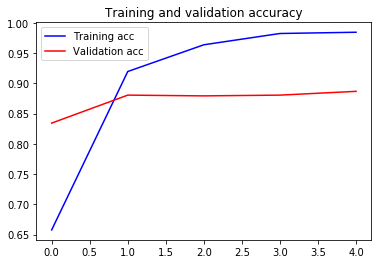

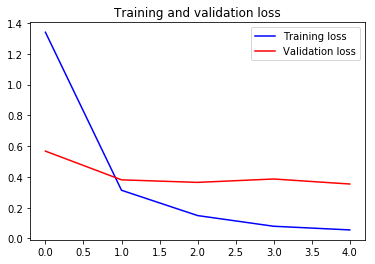

In [12]:
plot_training_process(history=history_xception)

Found 1600 images belonging to 21 classes.
100/100 [==============================] - 16s 159ms/step
No of errors = 181/1600


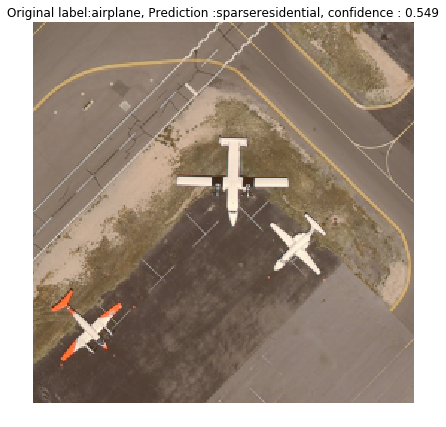

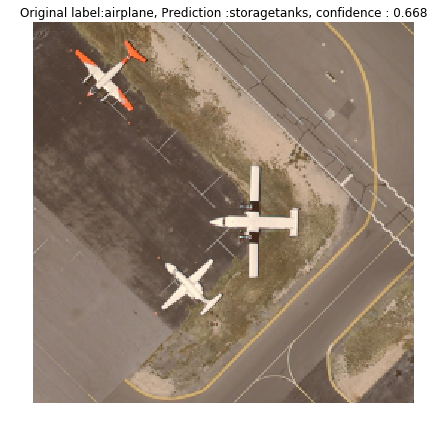

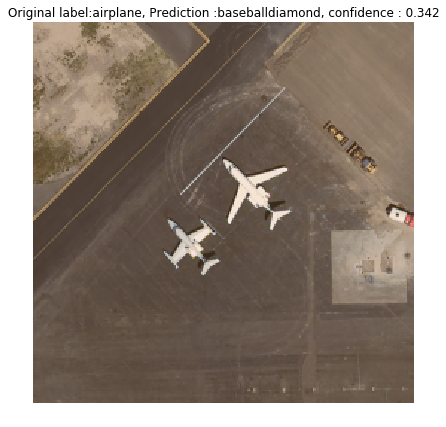

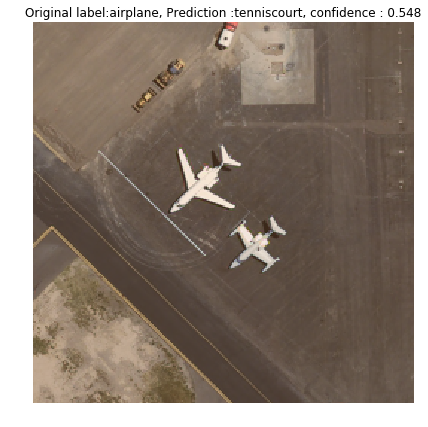

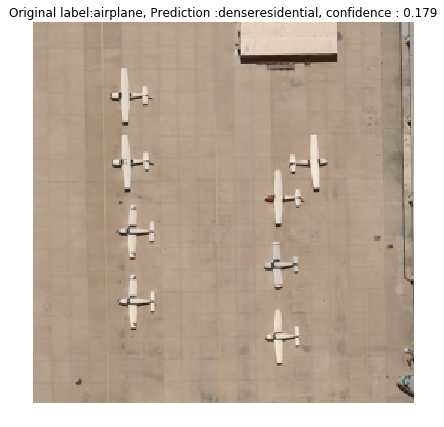

In [13]:
show_result(model_trained_xception, test_folder=test_folder, image_size=image_size)

# Experiment 2. Load pretrained model and retrain last 4 layers

In [14]:
model_xception_retrainable_layers = create_model_with_retrainable_layers("xception", image_size=image_size)

<keras.engine.topology.InputLayer object at 0x7fe8a7023978> False
<keras.layers.convolutional.Conv2D object at 0x7fe8a7023e48> False
<keras.layers.normalization.BatchNormalization object at 0x7fe8a6f98eb8> False
<keras.layers.core.Activation object at 0x7fe8a6f7c940> False
<keras.layers.convolutional.Conv2D object at 0x7fe8a6f319b0> False
<keras.layers.normalization.BatchNormalization object at 0x7fe8a7007a90> False
<keras.layers.core.Activation object at 0x7fe8a7055f28> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fe8a707b4a8> False
<keras.layers.normalization.BatchNormalization object at 0x7fea7007a7b8> False
<keras.layers.core.Activation object at 0x7fea700872e8> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fea70060518> False
<keras.layers.normalization.BatchNormalization object at 0x7fea700eb048> False
<keras.layers.convolutional.Conv2D object at 0x7fe8a704c320> False
<keras.layers.pooling.MaxPooling2D object at 0x7fea701384a8> False
<keras.layer

In [15]:
model_trained_xception_retrainable_layers, history_xception_retrainable_layers = train_model(epochs=20, lr=5e-5, model=model_xception_retrainable_layers, train_folder=train_folder,
            test_folder=test_folder, train_batchsize=train_batchsize, val_batchsize=val_batchsize, image_size=image_size,
                                                     filename="xception_lats4.h5")

Found 6803 images belonging to 21 classes.
Found 1600 images belonging to 21 classes.
Epoch 1/20
106/106 [==============================] - 82s 777ms/step - loss: 0.9083 - acc: 0.7592 - val_loss: 0.8627 - val_acc: 0.8319
Epoch 2/20
106/106 [==============================] - 81s 761ms/step - loss: 0.2068 - acc: 0.9394 - val_loss: 1.0718 - val_acc: 0.8131
Epoch 3/20
106/106 [==============================] - 80s 758ms/step - loss: 0.1134 - acc: 0.9662 - val_loss: 0.6218 - val_acc: 0.8662
Epoch 4/20
106/106 [==============================] - 80s 758ms/step - loss: 0.0670 - acc: 0.9810 - val_loss: 0.6424 - val_acc: 0.8738
Epoch 5/20
106/106 [==============================] - 80s 759ms/step - loss: 0.0603 - acc: 0.9809 - val_loss: 0.6825 - val_acc: 0.8831
Epoch 6/20
106/106 [==============================] - 80s 759ms/step - loss: 0.0332 - acc: 0.9891 - val_loss: 0.6297 - val_acc: 0.8856
Epoch 7/20
106/106 [==============================] - 81s 762ms/step - loss: 0.0259 - acc: 0.9922 - val_

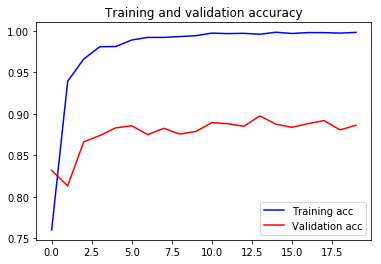

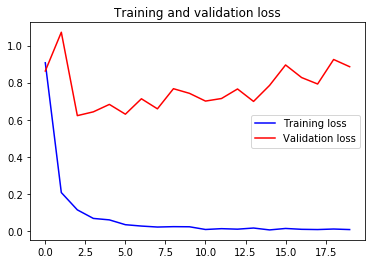

In [16]:
plot_training_process(history_xception_retrainable_layers)

Found 1600 images belonging to 21 classes.
100/100 [==============================] - 16s 162ms/step
No of errors = 182/1600


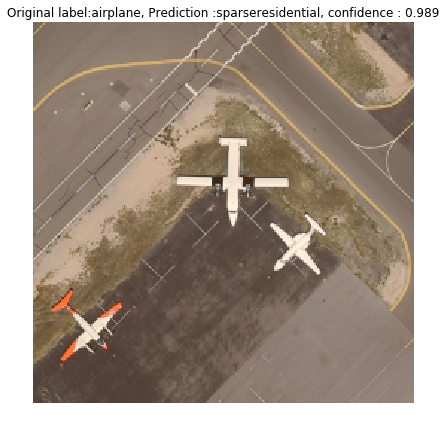

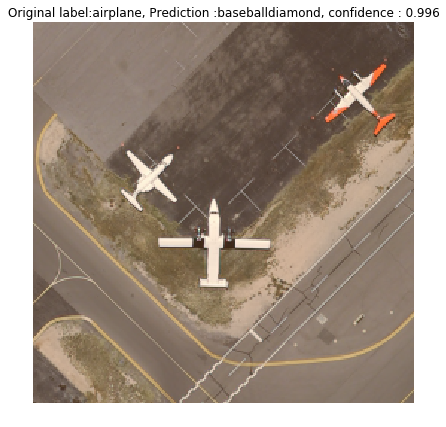

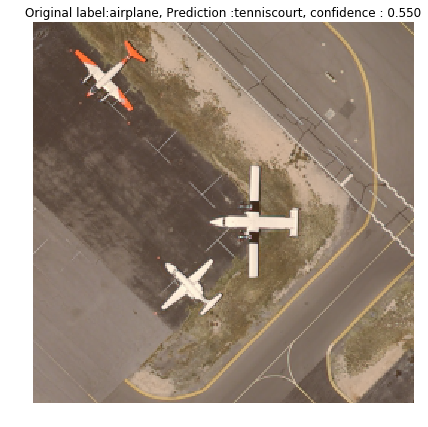

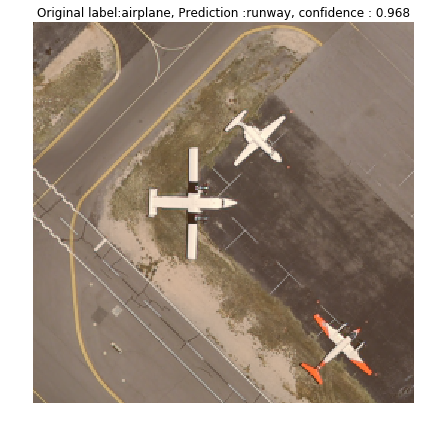

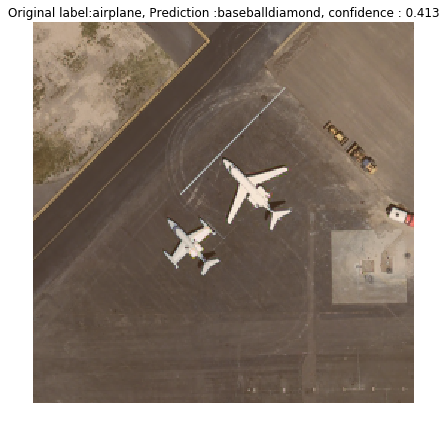

In [17]:
show_result(model=model_trained_xception_retrainable_layers, image_size=image_size, test_folder=test_folder)